# Processing images with Neural Networks
After introducing the concept of Neural Networks (in its simplest form, that is the MLP), we are now ready to move back to the main topic of this course: **image reconstruction**. In the following, we will quickly recall the problem setup, mainly to fix some notation, and we will discuss how the basic architecture of MLP can be modified to address the task of image reconstruction.
This discussion will include the concept of **Convolutional Neural Networks (CNN)**, a particular modifications to the already-described MLP that allows for a more flexible processing of the input image, which generalizes better on new data by imitating the behavior of the human eye. To this aim, we will introduce the concept of **Receptive Field (RF)**, as the sub-portion of input image that provides the context in image reconstruction. To improve the RF, we will then discuss **U-Net**, arguably the most-used neural network architecture for every possible task related to images, highlighiting its main advantages and limitations.

Finally, we will introduce **Vision Transformers (ViT)**: a recently-introduced architecture which seems to perform particularly well on computer vision tasks trying to imitate the success that Transformers already had in Language Processing.


## A Brief Recall on Image Reconstruction

In the first module of this course, you already discussed the problem of image reconstruction from measurements acquired via **linear operators**. In particular, this was done by considering the following acquisition system:

$$
y^\delta = Kx_{true} + e,
$$

where $K \in \mathbb{R}^{m \times n}$ represents the **acquisition operator**, $x_{true} \in \mathbb{R}^n$ is the **true datum** we want to reconstruct (here represented in *vectorized* form), $e \in \mathbb{R}^m$ is the **measurement noise**, which satisfies $|| e ||_2 \leq \delta$, and $y^\delta \in \mathbb{R}^m$ is the **acquired datum**.

The task of image reconstruction is to approximate $x_{true}$ (denoted as $x^*$ in the following), starting from $y^\delta$ and, possibly, some information about the noise—e.g., $e$ could be Gaussian noise with zero mean and a given standard deviation $\sigma>0$.

For simplicity, in the first part of this course, $x_{true}$ was usually represented as a matrix of shape $n_x \times n_y$, where $n_x$ and $n_y$ denote the number of pixels per row and column, respectively. Clearly, this implies that $(n_x, n_y)$ satisfies $n_x \cdot n_y = n$. Similarly, the acquired measurement data $y^\delta$ is also treated as an image, with shape $m_x \times m_y$ such that $m_x \cdot m_y = m$.

```{note}
Due to the dimensions of the reconstructed image $x_{true}$, the operator $K$ **cannot** be stored in memory. For this reason, we typically consider an **operator** that *simulates* the application of $K$ to the input $x_{true}$.
```

We also recall that most classical methods for solving the image reconstruction problem defined above rely on the **regularized least squares optimization problem**:

$$
\min_{x \in \mathcal{X}} \frac{1}{2} || K x - y^\delta ||_2^2 + \lambda R(x),
$$

where $\mathcal{X}$ denotes the image domain (typically, $\mathcal{X} = \{ x \geq 0 \}$), $R(x)$ is the regularizer, which incorporates prior information about the solution, and $\lambda > 0$ is the *regularization parameter*.

This optimization problem is then solved using an *optimizer*, which depends on the mathematical properties of $R(x)$.

## Neural Networks for Image Processing

When working with neural networks, we need to take a slightly different approach. As we already noted in the previous sections, a neural network pipeline consists of two main components:

* A **model architecture**, defined by the type of layers, the number of layers ($L$), and the activation functions ($\rho$), and represented as $f_\Theta$ for simplicity.
* A **training set** $D$ containing $N$ pairs of input-output data, which is used to train the model by optimizing its parameters to perform the task described by $D$.

While we will describe the neural network model in detail in the next sections, we focus here on how the dataset is typically constructed for image processing tasks.

### End-to-End vs. Hybrid Approaches

A key distinction when using neural networks for image reconstruction is between the **end-to-end** approach and the **hybrid** approach.

* An **end-to-end** neural network is a model $f_\Theta$ trained to take the corrupted datum $y^\delta$ as input and **directly** compute the reconstruction, i.e., $x^* = f_\Theta(y^\delta)$, in a single forward pass. This approach is significantly faster than, for example, a regularized variational method. Moreover, due to the power and flexibility of neural networks, the visual quality of the reconstructed image is often superior. However, such methods are known to suffer from severe instabilities—for instance, the quality of the solution may degrade unexpectedly when $y^\delta$ is corrupted with additional noise. This makes them unreliable for applications such as medical imaging, where consistency between the solution and the measured data is crucial.

```{image} /imgs/end-to-end.png
:width: 600px
:align: center
```

* A **hybrid** algorithm for image reconstruction, on the other hand, alternates the application of a neural network with a step of a classical algorithm that ensures the solution remains consistent with the measurements. Due to the inherently iterative nature of this approach, these methods tend to be slower, often requiring multiple (sometimes hundreds of) applications of the neural network. Additionally, the consistency step may not always be parallelizable on a GPU, which further slows down the process due to the frequent transfer of data between the GPU and CPU. However, these models typically achieve comparable quality to end-to-end models while being significantly more stable, making them more suitable for applications such as medical imaging. 

```{image} /imgs/hybrid-approach.png
:width: 800px
:align: center
```

The class of hybrid algorithms is broad and includes methods such as Plug-and-Play (PnP), Algorithm Unrolling, and Deep Generative Priors. Later in this course, we will explore some of these methods, which are widely used in the literature.

### Self-Supervised Learning

How to build a training dataset for end-to-end neural network models is quite interesting. In fact, we already remarked that neural networks are usually trained in a **supervised** way, meaning that the training data is supposed to be composed on $N$ input-output pairs.
However, this would require to collect a set of $N$ pairs of corrupted image - associated ground truth solution, which is undoable in practice as it would require to acquire the exact same datum twice: once for the corrupted image, and once for the ground truth. Clearly, this is impossible to do most of the time, and in particular for applications such as medical imaging, where measuring a patient twice in a row would cause him to handle twice the radiation, with consequences on his health. Therefore, how to collect data such a dataset for image reconstruction?

The short answer is: **you dont**. 
Indeed, neural networks for image reconstruction are usually trained with a variant of the supervised learning approach, named **self-supervised learning**. The idea is as follows:

* Collect a set $\{ x^{(1)}, x^{(2)}, \dots, x^{(N)} \}$ of ground-truth images.
* **Synthetically** construct the associated corrupted measurement by considering the corruption operator $K$, a given noise variance $\sigma^2 > 0$, and computing $y^{(i)} = K x^{(i)} + e^{(i)}$ for any $i = 1, \dots, N$.
* Generate the final dataset as $D = \{ (y^{(1)}, x^{(1)}), (y^{(2)}, x^{(2)}), \dots, (y^{(N)}, x^{(N)}) \}$.

```{note}
Note that, compared to the classical notation we used previously, here we consider the training pair as $(y^{(i)}, x^{(i)})$ instead of $(x^{(i)}, y^{(i)})$. This is because the network should take as input the corrupted image $y^{(i)}$ and return a reconstructed solution $x^{(i)}$. 
```

## Preparing the data for Neural Network processing

### Reshaping
Data preparation for image processing tasks follows a set of simple, classical step, which is slightly different from the approach used in the previous module of this course. Indeed, classical imaging processing algorithm (variational methods) usually considers images to be either matrices of shape $n_x \times n_y$ (for grey-scale images) or $n_x \times n_y \times 3$ (for RGB images, where the last dimension refers to the channel dimension), which are then flattened to $n$-dimensional vectors of length $n$ where $n = n_x \cdot n_y$ or $n = n_x \cdot n_y \cdot 3$ to be left-multiplied by the corruption matrix $K \in \mathbb{R}^{m \times n}$. In neural network applications, since we would like to work with a **batch** of images in parallel, we usually consider an image as a **tensor** with shape $N \times c \times n_x \times n_y$, where:

* $N$ is the **number of images in each batch** (usually, $N = 1$ when working with a single image).
* $c$ is the **number of channels**, whose value is:
  * $c = 1$ for grey-scale images,
  * $c = 3$ for RGB images,
  * $c > 3$ for hyperspectral images, where $c$ contains all the hyperspectral information together.
* $n_x$ and $n_y$ are the number of rows and the number of columns of the image matrix, respectively.

```{warning}
Differently from classical methods, images are usually not flattened in neural network-based algorithms. Therefore, one should be careful when defining the corrupting operator $K$, which won't be a real matrix, rather it will be represented as a general operator $K: \mathbb{R}^{N \times c \times n_x \times n_y} \to \mathbb{R}^{N \times c' \times m_x \times m_y}$ such that $y = K(x)$.
Note then, when required, these operators should implement a *Transpose* counterpart, $x = K^T(y)$, that simulates the application of the transposed of the operator $K$ when seen as a matrix.  
All this structure has been already implemented on a few operators on the `IPPy` package, as we will see later in this course.
```

### Normalization
Normalization is the operation of re-scaling the features of a dataset so that they fit in the same, pre-determined range of values. For example, in the California Housing example from the previous section, we had multiple input features, some of which has values that are naturally larger (or smaller) than the others. For example, the size of the house in square foot or the distance from the city center will be tipically larger than its number of bedrooms. This imbalance in the feature range causes the model to focus more on those variables and partially ignoring the others. 
As a consequence, every ML-based algorithm requires its training data to be pre-processed so that all the features have approximately the same magnitude. This process (called normalization), is mostly done in two possible ways:

* **min-max normalization:** Each input data is re-scaled into the range $[0, 1]$ by a min-max rescaling, i.e. 
    $$
        x^{(i)} \leftarrow \frac{x^{(i)} - m}{M - x},
    $$
    where $M$ and $m$ are the maximum of the training data and its minimum, respectively.

* **gaussian normalization:** Each input data is re-scaled so that its mean becomes 0 and its standard deviation becomes 1, i.e.
    $$
        x^{(i)} \leftarrow \frac{x^{(i)} - \mu}{\sigma},
    $$
    where $\mu$ is the mean of the training set $D$, while $\sigma$ is its standard deviation.

While Gaussian normalization is the most commonly used nowadays for any general-use machine learning task, it is meaningful for image processing task, as by definition, after normalization,half of the pixels are negative, and negative pixels has no physical intepretation. 

For this reason, in the field of image processing, it is most common to employ min-max normalization (and this is the approach we will follow from now on). Let's define the Python function to perform dataset normalization, which will be useful in the following.

In [1]:
import torch

def normalize(x: torch.Tensor) -> torch.Tensor:
    """
    Assuming the input x is a Pytorch tensor with shape (N, c, n_x, n_y), it normalizes it
    with min-max normalization and returns a tensor with the same shape, in the range [0, 1].
    """
    M, m = x.max(dim=0, keepdim=True)[0], x.min(dim=0, keepdim=True)[0]
    return (x - m) / (M - m)

### Data type
A last common pre-processing step for image processing tasks is that of converting all the data into the same data type. We already discuss that the main datatypes for Pytorch tensors are `uint8`, `float16`, `float32` and `float64`. 
Classically, images are converted into `float32` as it is a good trade-off between efficiency and precision:

In [2]:
# Convert a tensor x to float32
x = torch.tensor([1, 2, 3])
x = x.to(torch.float32)

## Dataset and Dataloading

Now that we discussed how data should be prepared, we are ready to define a `Dataset` class in `torch` to work with our data. For this example we will consider an example which we will use multiple time throughout this module: the **Mayo's dataset**.

### The Mayo's dataset
The Mayo's dataset is a commonly-used dataset for benchmarking algorithms for Computed Tomography (CT) image reconstruction from sparse measurement. It can be downloaded from the following link: [Mayo's Dataset Download](https://drive.google.com/drive/folders/13BEiz6t57qSbwBpCtfqllmYTLmkhQeFE?usp=share_link). 

This dataset comprises a total of $N = 3305$ training images and $N = 327$ test images, representing the CT scan of 10 human chests.

```{image} /data/Mayo/test/C081/0.png
:width: 400px
:align: center
```

Each image is a $512 \times 512$ grey-scale image representing, for each patient, a different **slice** of the scan, from the top of the chest to the bottom. The data is saved as `uint8` for space-efficiency. The file structure of the data folder is as follows:

```
data
|--- Mayo
|------| train
|----------| C002
|-------------| 0.png
|-------------| ...
|----------| C004
|-------------| 0.png
|-------------| ...
|----------| C012
|-------------| 0.png
|-------------| ...
|----------| C016
|-------------| 0.png
|-------------| ...
|----------| C027
|-------------| 0.png
|-------------| ...
|----------| C030
|-------------| 0.png
|-------------| ...
|----------| C050
|-------------| 0.png
|-------------| ...
|----------| C052
|-------------| 0.png
|-------------| ...
|----------| C067
|-------------| 0.png
|-------------| ...
|----------| C077
|-------------| 0.png
|-------------| ...
|------| test
|----------| C081
|-------------| 0.png
|-------------| ...
```

Where each folder inside e.g. the `train` folder represents a patient, whose slice are indicated with an increasing integer number, in `.png` format. We need to take care of this folder structure when we load data into memory via the custom `Dataset` class.

When working with self-supervised learning as we will do next, it is common practice to define a dataset that only returns the input $x^{(i)}$, and the corresponding corrupted data $y^{(i)} = Kx^{(i)} + e^{(i)}$ is usually generated online inside the training loop itself. Thus, we expect our `Dataset` class to only return $x^{(i)}$ when the `__getitem__(self, idx)` method is called.

In [3]:
import glob

import torch
from torch.utils.data import Dataset
from torchvision import transforms

from PIL import Image
import numpy as np

class MayoDataset(Dataset):
    def __init__(self, data_path, data_shape):
        super().__init__()

        self.data_path = data_path
        self.data_shape = data_shape

        # We expect data_path to be like "./data/Mayo/train" or "./data/Mayo/test"
        self.fname_list = glob.glob(f"{data_path}/*/*.png")

    def __len__(self):
        return len(self.fname_list)
    
    def __getitem__(self, idx):
        # Load the idx's image from fname_list
        img_path = self.fname_list[idx]

         # To load the image as grey-scale
        x = Image.open(img_path).convert("L")

        # Convert to numpy array -> (512, 512)
        x = np.array(x) 

        # Convert to pytorch tensor -> (1, 512, 512) <-> (c, n_x, n_y)
        x = torch.tensor(x).unsqueeze(0)

        # Resize to the required shape
        x = transforms.Resize(self.data_shape)(x) # (1, n_x, n_y)

        # Normalize in [0, 1] range
        x = (x - x.min()) / (x.max() - x.min())

        return x

    def get_patient_and_slice(self, idx):
        """
        A utility function. Given an idx, it returns the patient ID and the number of slice of
        that patient corresponding to the idx's datapoint.
        """
        fname = self.fname_list[idx]
        patient_id = fname.split('/')[-2]
        slice_n = fname.split('/')[-1]
        return patient_id, slice_n

Note that our dataset now returns a normalized grey-scale image of the required shape as an $(1, n_x, n_y)$ pytorch tensor. The batch dimension $N$ will be automatically provided by the `DataLoader` class, as shown below.

torch.Size([4, 1, 256, 256])


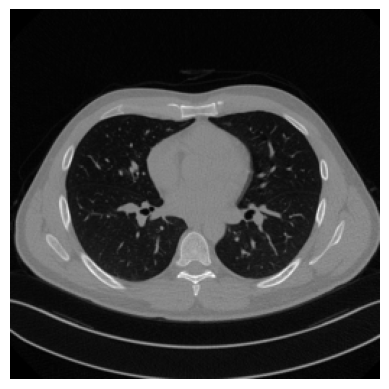

In [4]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define dataset and dataloader (only train for now)
train_data = MayoDataset(data_path="../data/Mayo/train", data_shape=256)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)

# Get a sample batch
x = next(iter(train_loader))
print(x.shape)

# Visualize the sample with matplotlib (different everytime!)
plt.imshow(x[0].squeeze(), cmap='gray')
plt.axis('off')
plt.show()

Now that the data is ready, we need one more step before going back to neural networks: defining imaging operators.

While this step could be theoretically done by simply combining functions from existing libraries, for simplicity we will use functions from the package `IPPy`, which is meant to simplify the process.